In [3]:
#%%
import shutil, json, sys, os, pickle, h5py, scipy
from os import path, chmod
import numpy as np
import pandas as pd 
from yacs.config import CfgNode as CN

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from lfads_tf2.subclasses.behavior.models import BehaviorLFADS
from lfads_tf2.tuples import LoadableData, LFADSInput
from lfads_tf2.utils import load_posterior_averages, restrict_gpu_usage, unflatten
restrict_gpu_usage(0)

from nomad.models import AlignLFADS
from nomad.tuples import AlignInput, SingleModelOutput, AlignmentOutput
from nomad.defaults import get_cfg_defaults

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(
    True
)

In [ ]:
#%% ===== FILE SETTINGS =====
DAY0_FILE = 'Jango_20150730_001' 
#%% ===== NOMADINTERFACE SETTINGS =====
RUN_ID = 131
NORMALIZED = True
SMOOTH_MS = 20
BLOCKED_VALID_SPLIT = True # Whether to split tv blockwise to minimize overlap
MAX_SHARED_PERC = 0.05 # The max percentage of shared train/valid samples
#%% ===== DATA PARAMETERS =====
BIN_SIZE_MS = 20 # ms
#%% ===== ALIGNMENT PARAMETERS =====
ALIGN_CFG_FILE = 'align_jango_lfl.yaml'
#%% ===== DECODING PARAMETERS =====
N_HISTORY = 3
PREDICTOR = 'gen_states' 
KIN_FIELD = 'force' 
COND_SEP_FIELD = 'tgtDir'

Loading the Day 0 and Day K datasets

* Isometric force task 
* Day 0 and Day 95
* Decoding force
* 20 ms bins

<div>
<img src="behavior.png" width="500"/>
</div>

In [2]:
with open('day0.pkl', 'rb') as f: 
    d0 = pickle.load(f)
    day0_ni = d0['data']
    day0_datadict = d0['datadict']

with open('dayk.pkl', 'rb') as f: 
    dk = pickle.load(f)
    dayk_ni = dk['data']
    dayk_datadict = dk['datadict']

Loading a pre-trained LFADS Day 0 model and getting the output

<div>
<img src="step1.png" width="1000"/>
</div>

In [3]:
day0_ni.load_pbt_lfads_model(BIN_SIZE_MS, run_id=RUN_ID)

model = BehaviorLFADS(model_dir=day0_ni.best_model_path)
model.cfg['MODEL']['SAMPLE_POSTERIORS'] = False # pass means 

sampling_data = LoadableData(
    train_data={'lfads_'+DAY0_FILE+'.h5': day0_datadict['train_data']},
    valid_data={'lfads_'+DAY0_FILE+'.h5': day0_datadict['valid_data']},
    train_ext_input=None,
    valid_ext_input=None,
    train_behavior=None,
    valid_behavior=None, 
    train_inds={'lfads_'+DAY0_FILE+'.h5': day0_datadict['train_inds']}, 
    valid_inds={'lfads_'+DAY0_FILE+'.h5': day0_datadict['valid_inds']}
)
sampling_output = model.sample_and_average(loadable_data=sampling_data, save=False, merge_tv=True)
lfads_gen_states = sampling_output.gen_states

day0_ni.dataset.merge_data_to_df(lfads_gen_states,
                            'lfads_gen_states',
                            smooth_overlaps=True,
                            smooth_pwr = 2,
                            overwrite=True)

extract_fields = ['lfads_'+PREDICTOR, KIN_FIELD] 
extract_params = {
    'calculate_params': {
        'name': 'moveOnset',
        'threshold': 0.15
    },
    'align_params': {
        'point': 'backward_move_onset',
        'window': (0.25, 0.5)
    },
    'selection': {
        'result': 'R'
    },
    'margins': 0.0
}
cond_sep_data = analyzer.get_aligned_data_fields(day0_ni.dataset,
                                                extract_fields,
                                                extract_params,
                                                rej_conds=[],
                                                cond_sep_field=COND_SEP_FIELD)

INFO: best_model_path has now been set to /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/pbt_best_model/
Loading model from /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/pbt_best_model/.
This `lfads_tf2` may not match the one used to create the model.
Loading datasets with prefix lfads from /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/lfads_input
Restoring the most recent model.
Posterior sample and average on 1520 segments.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you ca

Training a decoder on Day 0 LFADS output

* Wiener filter
* 4 bins of history (80 ms total)
* Trained using 10x cross-validation and L2 regularization sweep

Testing l2=0.1
Testing l2=0.16237767391887217
Testing l2=0.26366508987303583
Testing l2=0.42813323987193935
Testing l2=0.6951927961775606
Testing l2=1.1288378916846888
Testing l2=1.8329807108324356
Testing l2=2.9763514416313175
Testing l2=4.832930238571752
Testing l2=7.847599703514611
Testing l2=12.742749857031335
Testing l2=20.6913808111479
Testing l2=33.59818286283781
Testing l2=54.555947811685144
Testing l2=88.58667904100822
Testing l2=143.8449888287663
Testing l2=233.57214690901213
Testing l2=379.2690190732246
Testing l2=615.8482110660261
Testing l2=1000.0
Optimal L2 Regularization value: 20.6913808111479


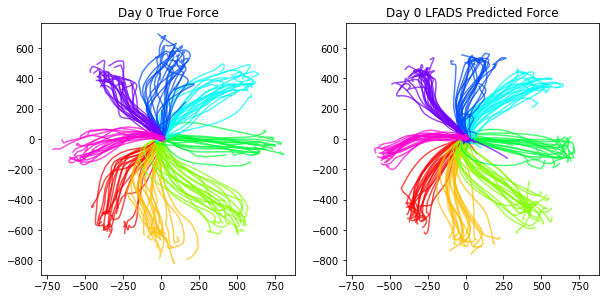

LFADS Predicted Force R2 : 0.965


In [4]:
trial_force = nutils.remove_baseline_offset(cond_sep_data[KIN_FIELD][1])
trial_rates = cond_sep_data['lfads_'+PREDICTOR][1]
vaf_force, trial_force_wf, trial_force_preds, W_force = ndec.WF_decode_train(
    trial_rates, trial_force, metric='r2_var_weight')

%matplotlib inline
nplt.plot_2d_trajectories([trial_force, trial_force_preds], titles=['Day 0 True Force', 'Day 0 LFADS Predicted Force'], integrate=False)
print('LFADS Predicted Force R2 : {}'.format(np.round(vaf_force, 3)))

Passing Day K data through the Day 0 model as-is

In [5]:
model = BehaviorLFADS(model_dir=day0_ni.best_model_path)
sampling_data = LoadableData(
    train_data={'lfads_'+DAY0_FILE+'.h5': dayk_datadict['train_data']},
    valid_data={'lfads_'+DAY0_FILE+'.h5': dayk_datadict['valid_data']},
    train_ext_input=None,
    valid_ext_input=None,
    train_behavior=None,
    valid_behavior=None, 
    train_inds={'lfads_'+DAY0_FILE+'.h5': dayk_datadict['train_inds']}, 
    valid_inds={'lfads_'+DAY0_FILE+'.h5': dayk_datadict['valid_inds']}
)
dayk_sampling_output = model.sample_and_average(loadable_data=sampling_data, save=False, merge_tv=True)

Loading model from /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/pbt_best_model/.
This `lfads_tf2` may not match the one used to create the model.
Loading datasets with prefix lfads from /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/lfads_input
Restoring the most recent model.
Posterior sample and average on 1514 segments.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1514/1514 [==================================================] - 19s 12ms/dat

In [6]:
lfads_gen_states = dayk_sampling_output.gen_states

dayk_ni.dataset.merge_data_to_df(lfads_gen_states,
                            'lfads_gen_states',
                            smooth_overlaps=True,
                            smooth_pwr = 2,
                            overwrite=True)

dayk_cond_sep = analyzer.get_aligned_data_fields(dayk_ni.dataset,
                                                extract_fields,
                                                extract_params,
                                                rej_conds=[],
                                                cond_sep_field=COND_SEP_FIELD)

INFO: Added lfads_gen_states to master dataframe
218 trials were successfully created.
218 trials were successfully created.
Calculating moveOnset for successful trials.
INFO: data param to use for move onset calculation not specified. Using kin_v
1 trials failed moveOnset calculation and were moved to Dataset.rejected_trials.
Aligning trials.
Align Point: backward_move_onset
Align Window: (0.25, 0.5)
0 trials failed alignment and were moved to Dataset.rejected_trials.
27 trials selected.
27 trials selected.
27 trials selected.
27 trials selected.
28 trials selected.
28 trials selected.
27 trials selected.
26 trials selected.


Applying Day 0 decoder to Day K LFADS Output

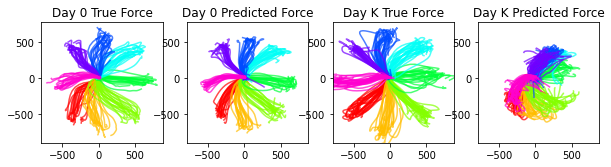

LFADS Day K Predicted Force R2 : 0.633


In [7]:
dayk_true_force = nutils.remove_baseline_offset(dayk_cond_sep[KIN_FIELD][1])
dayk_r2, _, dayk_force_preds, *_, = ndec.WF_decode_predict(
    W_force,
    dayk_cond_sep['lfads_'+PREDICTOR][1],
    dayk_true_force, 
    metric='r2_var_weight',
    n_history=N_HISTORY)

nplt.plot_2d_trajectories([trial_force, trial_force_preds, dayk_true_force, dayk_force_preds], 
    titles=['Day 0 True Force', 'Day 0 Predicted Force', 'Day K True Force', 'Day K Predicted Force'], 
    integrate=False)
print('LFADS Day K Predicted Force R2 : {}'.format(np.round(dayk_r2, 3)))

Prepare NoMAD alignment model

<div>
<img src="step2.png" width="1000"/>
</div>

In [8]:
day0_ni.make_new_alignment_runpath()

align_cfg = get_cfg_defaults()
cfg_update_path = '/home/bkarpo2/bin/nomad_dev/alignment_analysis/run_scripts/config/align_jango_lfl.yaml'
align_cfg.merge_from_file(cfg_update_path)
align_cfg.MODEL.DATA_DIM = 100
align_cfg.MODEL.DAY0_MODEL_TYPE = 'dimreduced'
align_cfg.MODEL.SEQ_LEN =  int(60 / 0.02)
align_cfg.TRAIN.MODEL_DIR = day0_ni.best_model_path
align_cfg.TRAIN.ALIGN_DIR = day0_ni.alignpath
align_cfg.TRAIN.NI_MODE = True
align_cfg.TRAIN.USE_TB = False
align_cfg.freeze()

align_input = AlignInput(
    day0_train_data=day0_datadict['train_data'],
    day0_valid_data=day0_datadict['valid_data'],
    dayk_train_data=dayk_datadict['train_data'],
    dayk_valid_data=dayk_datadict['valid_data'],
    day0_train_inds=day0_datadict['train_inds'],
    day0_valid_inds=day0_datadict['valid_inds'],
    dayk_train_inds=dayk_datadict['train_inds'],
    dayk_valid_inds=dayk_datadict['valid_inds'])
model = AlignLFADS(cfg_node=align_cfg)
model.load_datasets(align_input)

INFO: Base alignment runpath found at /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/alignment
Updated alignment run path to /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/alignment/align_run_013
INFO: Making /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/alignment/align_run_013
Initializing new aligner
Loading model from /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/alignment/align_run_013/pbt_model.
This `lfads_tf2` may not match the one used to create the model.
Loading datasets with prefix lfads from /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/lfads_input
Restoring the most recent model.
Loading model from /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/alignment/align_run

This is how NoMAD would train...

In [9]:
N_ITERATIONS = 5
for i in range(N_ITERATIONS):
    results = model.train_epoch()

Epoch 1/9999, Patience: 0, LR: 4.00E-04
5/5 [==============================] - 18s 4s/step
    loss: 51.591 -     kl: 51.444 -     nll: 0.359 - gnorm: 6780599.000 - kl_gnorm: 678.059 - nll_gnorm: 0.032
val_loss: 37.624 - val_kl: 37.589 - val_nll: 0.351
Epoch 2/9999, Patience: 0, LR: 4.00E-04
5/5 [==============================] - 17s 3s/step
    loss: 25.687 -     kl: 25.506 -     nll: 0.347 - gnorm: 2359011.750 - kl_gnorm: 235.897 - nll_gnorm: 0.056
val_loss: 28.844 - val_kl: 28.776 - val_nll: 0.341
Epoch 3/9999, Patience: 0, LR: 4.00E-04
5/5 [==============================] - 18s 4s/step
    loss: 19.492 -     kl: 19.280 -     nll: 0.338 - gnorm: 1838010.000 - kl_gnorm: 183.797 - nll_gnorm: 0.074
val_loss: 23.536 - val_kl: 23.437 - val_nll: 0.331
Epoch 4/9999, Patience: 0, LR: 4.00E-04
5/5 [==============================] - 15s 3s/step
    loss: 17.482 -     kl: 17.240 -     nll: 0.329 - gnorm: 2151496.000 - kl_gnorm: 215.134 - nll_gnorm: 0.088
val_loss: 18.427 - val_kl: 18.300 - val

The current NoMAD model has not been optimized for fast training as of yet. As we move towards online demonstrations, we can: 
* Reduce amount of training data  
* Further tune HPs (batch size, learning rate)
* Reduce # training epochs (hard stop)

Clearly this is not appropriate for instantaneous updates. Training will likely require minutes of data and minutes to train.

As of now, we envision NoMAD being run continuously in the background, as such: 

<div>
<img src="usage_schematic.png" width="750"/>
</div>

Loading a pretrained NoMAD model

In [10]:
align_input = AlignInput(
    day0_train_data=day0_datadict['train_data'],
    day0_valid_data=day0_datadict['valid_data'],
    dayk_train_data=dayk_datadict['train_data'],
    dayk_valid_data=dayk_datadict['valid_data'],
    day0_train_inds=day0_datadict['train_inds'],
    day0_valid_inds=day0_datadict['valid_inds'],
    dayk_train_inds=dayk_datadict['train_inds'],
    dayk_valid_inds=dayk_datadict['valid_inds']
)
model = AlignLFADS(align_dir='/snel/share/runs/nomad/brianna/ray_results/220217_jango_pairwise_outliers_removed/tuneAlign_380_DATASET_TYPE=XDS,DAY0_FILE=Jango_20150730_001,DAYK_FILE=Jango_20151102_001,KIN_FIELD=force,MONKEY=Jango,RUN_ID=131_2022-02-18_15-50-16_aq7guvw/align_dir')
model.load_datasets(align_input)

Loading aligned model from /snel/share/runs/nomad/brianna/ray_results/220217_jango_pairwise_outliers_removed/tuneAlign_380_DATASET_TYPE=XDS,DAY0_FILE=Jango_20150730_001,DAYK_FILE=Jango_20151102_001,KIN_FIELD=force,MONKEY=Jango,RUN_ID=131_2022-02-18_15-50-16_aq7guvw/align_dir
Loading model from /snel/share/runs/nomad/brianna/ray_results/220217_jango_pairwise_outliers_removed/tuneAlign_380_DATASET_TYPE=XDS,DAY0_FILE=Jango_20150730_001,DAYK_FILE=Jango_20151102_001,KIN_FIELD=force,MONKEY=Jango,RUN_ID=131_2022-02-18_15-50-16_aq7guvw/align_dir/pbt_model.
This `lfads_tf2` may not match the one used to create the model.
Loading datasets with prefix lfads from /snel/share/share/derived/NW_Emory_Data_Sharing/Jango/2015/Jango_20150730_001/binsize_20ms/run_131/lfads_input
Restoring the most recent model.
Loading model from /snel/share/runs/nomad/brianna/ray_results/220217_jango_pairwise_outliers_removed/tuneAlign_380_DATASET_TYPE=XDS,DAY0_FILE=Jango_20150730_001,DAYK_FILE=Jango_20151102_001,KIN_FI

Getting the alignment output

In [11]:
def get_model_output(aligned=True, use_dayk_data=True):
    """Get the output from the alignment model."""
    # perform sample and average
    sampling_output = model.sample_and_average(
        aligned_model=aligned, 
        dayk_data=use_dayk_data, 
        batch_size=500,
        save=False,
        merge_tv=True,
        lve=False,
        restore_weights=False)
    # return results in an organized namedtuple
    return SingleModelOutput(
            rates=sampling_output.rates,
            factors=sampling_output.factors,
            gen_inputs=sampling_output.gen_inputs,
            gen_states=sampling_output.gen_states)

d0_output = get_model_output(aligned=False, use_dayk_data=False)
dk_output = get_model_output(aligned=False, use_dayk_data=True)
aligned_output = get_model_output(aligned=True, use_dayk_data=True)
aligned_output = SingleModelOutput(rates=[aligned_output.rates], 
                                factors=[aligned_output.factors], 
                                gen_inputs=[aligned_output.gen_inputs],
                                gen_states=[aligned_output.gen_states])

alignment_output = AlignmentOutput(day0=d0_output, dayk=dk_output, aligned=aligned_output)

aligned_data = alignment_output.aligned.gen_states
dayk_ni.dataset.merge_data_to_df(aligned_data[-1], 
                                       'aligned_lfads_' + PREDICTOR,
                                       smooth_overlaps=True,
                                       overwrite=True)

extract_fields = [KIN_FIELD, 'aligned_lfads_'+PREDICTOR]
aligned_cond_sep = analyzer.get_aligned_data_fields(dayk_ni.dataset, 
                                           extract_fields, 
                                           extract_params, 
                                           cond_sep_field=COND_SEP_FIELD)
# aligned dayk rates 
dayk_avg_lfads_rates = aligned_cond_sep['aligned_lfads_' + PREDICTOR][0]
dayk_trial_lfads_rates = aligned_cond_sep['aligned_lfads_' + PREDICTOR][1]
# kinematics 
dayk_trial_force = aligned_cond_sep[KIN_FIELD][1]
dayk_trial_force = nutils.remove_baseline_offset(dayk_trial_force)

Sampling and averaging.
Posterior sample and average on 1520 segments.
1520/1520 [==================================================] - 8s 5ms/dataset
Posterior sample and average on 368 segments.
368/368 [==================================================] - 2s 5ms/dataset
Sampling and averaging.
Posterior sample and average on 1514 segments.
1514/1514 [==================================================] - 7s 5ms/dataset
Posterior sample and average on 360 segments.
360/360 [==================================================] - 2s 5ms/dataset
Sampling and averaging.
Posterior sample and average on 1514 segments.
1514/1514 [==================================================] - 7s 5ms/dataset
Posterior sample and average on 360 segments.
360/360 [==================================================] - 2s 5ms/dataset
INFO: Added aligned_lfads_gen_states to master dataframe
218 trials were successfully created.
Calculating moveOnset for successful trials.
INFO: data param to use for move on

Applying the Day 0 decoder

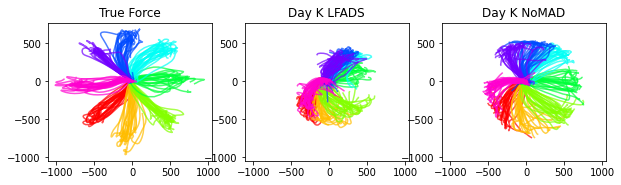

NoMAD Day K Predicted Force R2 : 0.842


In [12]:
dayk_vaf_force, dayk_trial_force_wf, dayk_aligned_force_preds = \
    ndec.WF_decode_predict(W_force, dayk_trial_lfads_rates, dayk_trial_force, metric='r2_var_weight', n_history=N_HISTORY)

nplt.plot_2d_trajectories([dayk_true_force, dayk_force_preds, dayk_aligned_force_preds], 
    titles=['True Force', 'Day K LFADS', 'Day K NoMAD'], 
    integrate=False)
print('NoMAD Day K Predicted Force R2 : {}'.format(np.round(dayk_vaf_force, 3)))

Pros
* Dynamics yield high accuracy predictions of behavior 
* Robust offline demonstrations for > 3 months 
* Based on LFADS, which has been used to model:
    * complex behaviors 
    * many brain areas (motor, cognitive, sensory)
    * LFP from ECoG
    * preliminary online results! (see Yahia's poster 3-A-6 tomorrow) 
* Alignment strategy may be compatible with other dynamics models (NODEs, iLQR-VAE)

Cons 
* Slower training does not allow for instantaneous updates 
    * May not work well when instabilities occur on minutes-long timescales 
        * Working on a solution to this (see my poster 3-F-55 tomorrow)
* KL-based alignment assumes same distribution of behavior across days 
* KL-based alignment may not generalize well to more complex behaviors
    * May sub other alignment strategies (GANs)